# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boeing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# XXX Testter resnet110 ?

# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}tmp
## Getting dataset
#!mkdir {PATH}
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

sz=299
arch=resnext50
#arch=resnet34
bs=132

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

def plot_the_confusion_matrix():
    log_preds,y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    accuracy_np(probs, y)
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)
    # precission = VP / (VP + FP)
    precision = cm[0][0]/(cm[0][1]+cm[0][0]);
    print("Precision : ", precision)
    # recall =  = VP / (VP + FN)
    recall = cm[0][0]/(cm[1][0]+cm[0][0]);
    print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    print("F2 : ", F2)
    return cm

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


# Training from sratch
We begin with an empty ResNext50 model.
First we compute the mean and standard deviation of all images to center them.
## Computing mean and stddev

In [5]:

import glob
import PIL
means = np.array([0.0,0.0,0.0])
files = [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(f'{PATH}train')] for val in sublist]
print("Input images number : ", len(files))
deviations = np.array([0.0,0.0,0.0])
#variances = np.array([0,0,0])
variance = np.array([0.0,0.0,0.0])
for image in files:
    #print(image)
    img_stats = PIL.ImageStat.Stat(PIL.Image.open(image), mask=None)
    means += np.array(img_stats.mean)
    variance += np.array(img_stats.var)

stddev = np.sqrt(variance) / len(files)
print("stddev with PIL : ", stddev)

mean = np.array(means) / len(files) / 255
print("Means with PIL : ", mean)
stats = (mean, stddev)

Input images number :  1310


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


stddev with PIL :  [1.54975 1.51391 1.60444]
Means with PIL :  [0.53286 0.5643  0.59667]


### Prepare data an model

In [6]:
image_size=128
#stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)

In [7]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

The model is realy deep as it make use of 168 layers.

How much input data do we get ?

(array([666.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 644.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([155.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

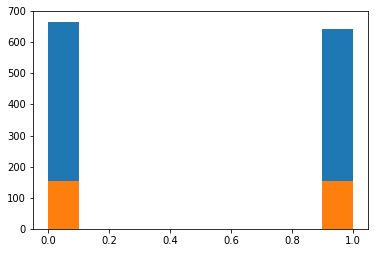

In [8]:
# This is the label for a val data
plt.hist(data.trn_y)
plt.hist(data.val_y)

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


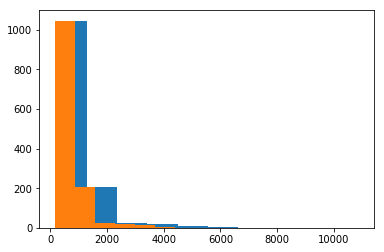

In [9]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz);
plt.hist(col_sz);

(array([ 23.,  51.,  49.,  74., 119., 179.,  77., 100.,  33.,  59.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6, 914.8, 992. ]),
 <a list of 10 Patch objects>)

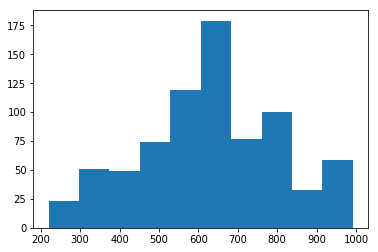

In [10]:
plt.hist(row_sz[row_sz < 1000])

We have few data

### Guess learning rate

 91%|█████████▏| 300/328 [00:17<00:01, 17.20it/s, loss=3.22] 

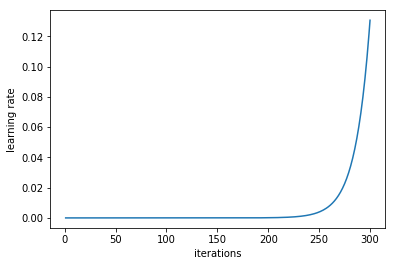

In [11]:
lrf=learn.lr_find(1e-10, end_lr=1)
learn.sched.plot_lr()

In [12]:
#?learn.lr_find

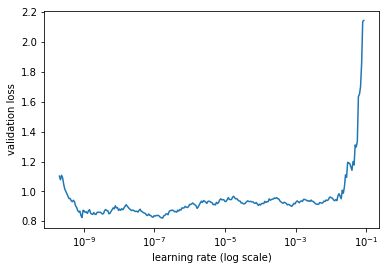

In [13]:
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                    
    0      0.81142    0.716812   0.458065  
    1      0.770269   0.704634   0.480645                    
    2      0.741789   0.704154   0.487097                    
    3      0.770416   0.694293   0.512903                    
    4      0.735326   0.696878   0.535484                    
    5      0.74027    0.693342   0.529032                    
    6      0.712799   0.694741   0.525806                    
    7      0.724256   0.692792   0.516129                    
    8      0.717919   0.697548   0.522581                    
    9      0.695779   0.692008   0.490323                    
    10     0.716288   0.695996   0.503226                    
    11     0.689096   0.691746   0.535484                    
    12     0.703584   0.699532   0.512903                    
    13     0.683006   0.69595    0.5                         
    14     0.731501   0.692815   0.516129                    
    15     0.704786   0.68

array([[150,   5],
       [148,   7]])

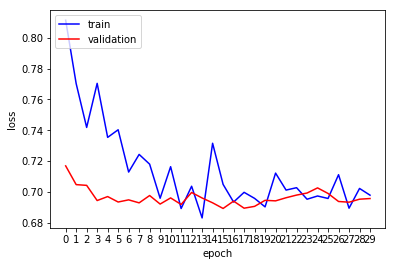

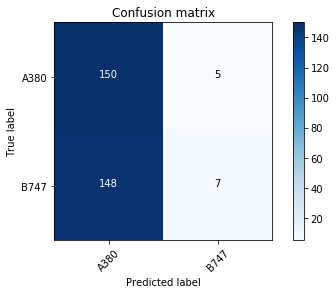

In [14]:
#F2 :  0.58 for lr=1e-2, image_size=128, batch_size=150, epoch=30 # val_loss begin at 4.4 and acc stay at 0.50 
#F2 :  0.02 for lr=1e-3, image_size=128, batch_size=256, epoch=30 # very erratic graph
#F2 :  0.55 for lr=1e-4, image_size=128, batch_size=256, epoch=30
#F2 :  0.11 for lr=1e-5, image_size=128, batch_size=256, epoch=30
#F2 :  0.55 for lr=1e-4, image_size=128, batch_size=128, epoch=30
#F2 :  0.49 (56.12 %) for lr=1e-4, image_size=128, batch_size=64


lr=1e-4
image_size=128
batch_size=64
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [15]:
#learn.sched.plot_loss()

The model had learn quite nothing. But it is not surprising with so small dataset.

## Fine tuning

epoch      trn_loss   val_loss   accuracy                  
    0      0.940396   0.736323   0.503226  
    1      0.909574   0.712123   0.535484                  
    2      0.879867   0.682585   0.603226                  
    3      0.832794   0.663889   0.603226                  
    4      0.80113    0.665556   0.609677                  
    5      0.76231    0.644285   0.606452                  
    6      0.72663    0.635287   0.635484                  
    7      0.693773   0.611124   0.648387                  
    8      0.662675   0.605802   0.677419                  
    9      0.62487    0.591073   0.696774                  
    10     0.591573   0.585735   0.670968                  
    11     0.565049   0.575241   0.7                       
    12     0.537133   0.541591   0.716129                  
    13     0.505539   0.53065    0.709677                  
    14     0.479101   0.529353   0.716129                  
    15     0.453898   0.523068   0.729032               

array([[131,  24],
       [ 45, 110]])

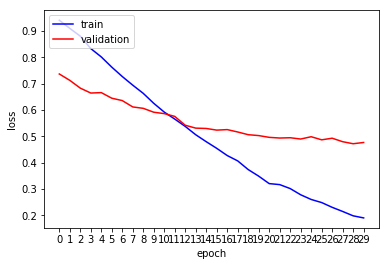

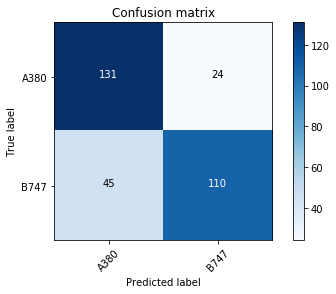

In [16]:
!rm -r {PATH}tmp

#F2 :  0.83 for image_size=128, batch_size=128, lr=1e-2
# F2 :  0.80 for image_size=128, batch_size=150, lr=1e-3
# F2 :  0.76 for image_size=128, batch_size=150, lr=1e-4 # good graph
# F2 :  0.83 for image_size=128, batch_size=150, lr=1e-2 # val loss goes up => overfitting
# F2 :  0.81 (acc 81.61 %) for image_size=128, batch_size=150, lr=1e-3 # val_loss go down, then slowly up
# F2 :  0.76 (acc 76.45 %) for image_size=128, batch_size=64, lr=1e-4 # good graph, val_loss slowly go down

image_size=128
batch_size=64
lr=1e-4
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

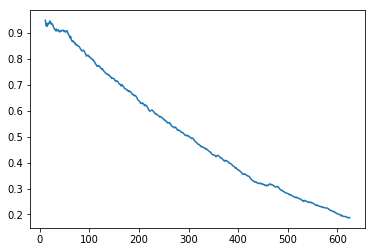

In [17]:
learn.sched.plot_loss()

## Data augmentation
Apply random operations on pictures to help the model to generalize.
Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

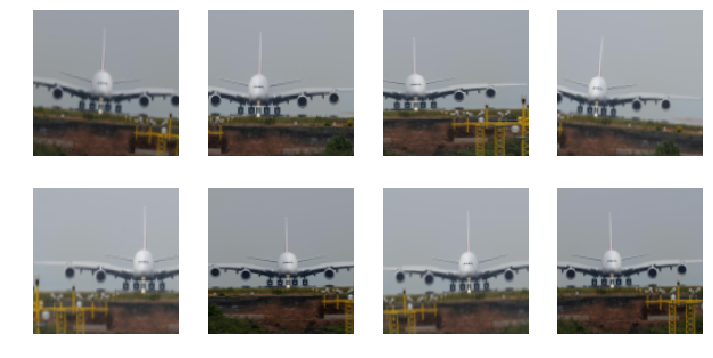

In [18]:
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)


def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.875801   0.668111   0.583871  
    1      0.794349   0.636772   0.667742                  
    2      0.696641   0.577963   0.712903                  
    3      0.602789   0.542088   0.735484                  
    4      0.525667   0.503054   0.751613                  
    5      0.456461   0.458946   0.777419                  
    6      0.378023   0.462388   0.796774                  
    7      0.316814   0.44646    0.8                       
    8      0.267342   0.448572   0.793548                  
    9      0.218364   0.434825   0.829032                  
    10     0.17909    0.430264   0.841935                  
    11     0.148228   0.424262   0.851613                  
    12     0.132105   0.418754   0.845161                  
    13     0.116361   0.432731   0.841935                  
    14     0.100902   0.448418   0.822581                  
    15     0.089182   0.445924   0.83871                

array([[134,  21],
       [ 26, 129]])

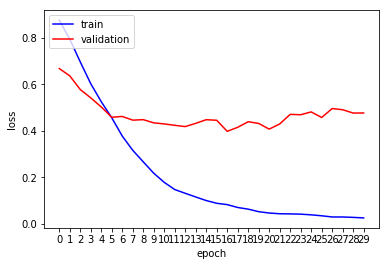

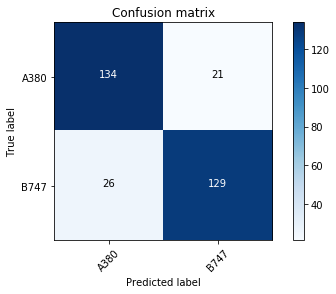

In [19]:
!rm -r {PATH}tmp
# F2 :  0.77 for image_size=128, batch_size=64, lr=1e-2 # val_loss don't go down
# F2 :  0.83 for image_size=128, batch_size=128, lr=1e-3, epoch=30
# F2 :  0.75 for image_size=128, batch_size=256, lr=1e-4, epoch=30
# F2 :  0.81 for image_size=128, batch_size=64, lr=1e-4 # good graph
# F2 :  0.85 (acc 84.19 %) for image_size=128, batch_size=64, lr=1e-3 # val_loss go slowy up
# F2 :  0.79 (acc 76.45 %) for image_size=128, batch_size=64, lr=1e-4 # val_loss still go down

image_size=128
batch_size=64
lr=1e-3
epoch=30

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

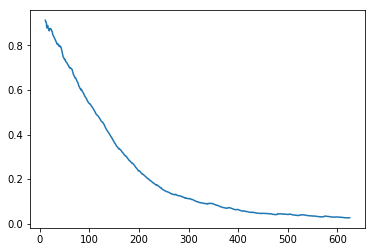

In [20]:
learn.sched.plot_loss()

## Multiple size

epoch      trn_loss   val_loss   accuracy                  
    0      0.797461   0.683304   0.651613  
After  1  epochs, the accuracy is  65.16 %
Saving to  resnext50_1_300_acc65.16_weights


epoch      trn_loss   val_loss   accuracy                  
    0      0.596517   0.509678   0.780645  
    1      0.499265   0.552382   0.741935                  
    2      0.408559   0.510362   0.787097                  
    3      0.350494   0.602635   0.764516                  
    4      0.285243   0.562134   0.790323                  
    5      0.233208   0.533871   0.787097                  
    6      0.186786   0.574635   0.790323                  
    7      0.151429   0.530481   0.825806                  
    8      0.12747    0.628377   0.806452                  
    9      0.109606   0.678021   0.780645                  
After  11  epochs, the accuracy is  78.06 %
Saving to  resnext50_11_64_acc78.06_weights


epoch      trn_loss   val_loss   accuracy                   
    0      0.057144   0.65875    0.796774  
    1      0.056478   0.638398   0.803226                   
    2      0.056139   0.560463   0.832258                   
    3      0.051298   0.599697   0.829032                   
    4      0.049444   0.595935   0.819355                   
    5      0.050834   0.556513   0.829032                   
    6      0.0467     0.543412   0.835484                   
    7      0.043272   0.525855   0.832258                   
    8      0.043439   0.525008   0.848387                   
    9      0.042504   0.547356   0.845161                   
After  21  epochs, the accuracy is  84.51 %
Saving to  resnext50_21_128_acc84.51_weights


epoch      trn_loss   val_loss   accuracy                   
    0      0.032035   0.60195    0.832258  
    1      0.028852   0.61104    0.835484                   
    2      0.026982   0.603696   0.845161                   
    3      0.029833   0.622196   0.829032                   
    4      0.028972   0.605123   0.83871                    
    5      0.027742   0.61204    0.83871                    
    6      0.0291     0.576509   0.845161                   
    7      0.027026   0.586478   0.86129                    
    8      0.023946   0.620778   0.825806                   
After  30  epochs, the accuracy is  82.58 %
Saving to  resnext50_30_300_acc82.58_weights
[[139  16]                                   
 [ 29 126]]
Precision :  0.896774193548387
Recall :  0.8273809523809523
F1 :  0.8606811145510835
F2 :  0.8403869407496977


array([[139,  16],
       [ 29, 126]])

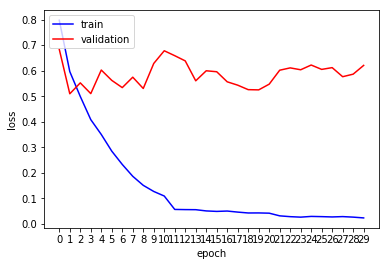

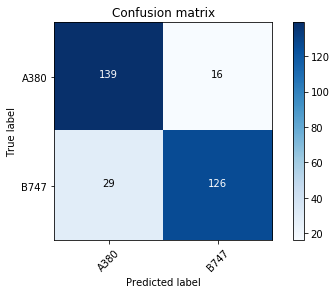

In [21]:
!rm -r {PATH}tmp
#F2 :  0.82 for learning_rate = 1e-2, dropout = [0.25,0.5], image_size = 128, batch_size = 150 # val_loss goes up
#F2 :  0.83 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150
#F2 :  0.61 for learning_rate = 1e-4, dropout = 0.5, image_size = 128, batch_size = 150 # bad graph
#F2 :  0.78 (acc 76.45 %) for learning_rate = 1e-3, dropout = [0.25,0.5], image_size = 128, batch_size = 150 # good graph
#F2 :  0.81 (acc 82.25 %) for learning_rate = 1e-3, dropout = [0.25,0.5], image_size = 128, batch_size = 64 # good, val_loss goes down



learning_rate = 1e-2
dropout = [0.25,0.5]
image_size = 128
batch_size = 64

global_results = collections.OrderedDict([])
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO), RandomFlip(), RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2),RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=dropout, pretrained=True)
learn.unfreeze()
training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 9],
]

for bs, sz, epoch in training_loop:
    lr=np.array([learning_rate/100,learning_rate/10,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)
plot_the_confusion_matrix()

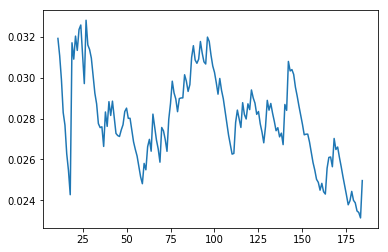

In [22]:
learn.sched.plot_loss()

## SGDR - Learning rate anealing

SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
    cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

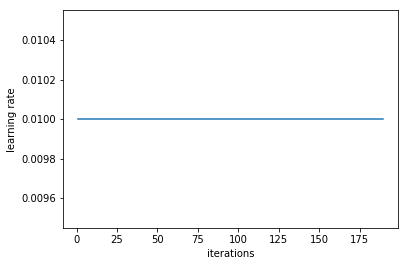

In [23]:
learn.sched.plot_lr()

Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 1  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.76104    0.585061   0.712903  
After  1  epochs, the accuracy is  71.29 %
Saving to  resnext50_1_300_acc71.29_weights
Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.536037   0.457789   0.777419  
    1      0.46109    0.385702   0.816129                    
    2      0.363577   0.36011    0.848387                    
    3      0.311459   0.315852   0.86129                     
    4      0.270921   0.318035   0.854839                    
    5      0.284069   0.256157   0.883871                    
    6      0.232592   0.275915   0.86129                     
    7      0.218288   0.231484   0.906452                    
    8      0.19664    0.217998   0.893548                    
    9      0.183003   0.272473   0.870968                    
After  11  epochs, the accuracy is  87.09 %
Saving to  resnext50_11_64_acc87.09_weights
Hyperparameters : Batch size= 150  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 128


epoch      trn_loss   val_loss   accuracy                    
    0      0.197849   0.21224    0.9       
    1      0.146169   0.241339   0.903226                    
    2      0.168411   0.225083   0.9                         
    3      0.179995   0.203274   0.919355                    
    4      0.147721   0.175006   0.932258                    
    5      0.143952   0.190206   0.929032                    
    6      0.117421   0.207771   0.919355                    
    7      0.107362   0.221223   0.912903                     
    8      0.140517   0.212412   0.916129                    
    9      0.138818   0.310753   0.867742                    
After  21  epochs, the accuracy is  86.77 %
Saving to  resnext50_21_128_acc86.77_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                     
    0      0.099243   0.249923   0.916129  
    1      0.114228   0.18523    0.919355                     
    2      0.087589   0.245833   0.903226                     
    3      0.094256   0.14888    0.932258                     
    4      0.106044   0.133564   0.945161                     
    5      0.100935   0.115048   0.96129                      
    6      0.17236    0.140892   0.948387                    
    7      0.12717    0.20844    0.9                          
    8      0.099427   0.166629   0.935484                     
    9      0.090578   0.148777   0.935484                     
After  31  epochs, the accuracy is  93.54 %
Saving to  resnext50_31_300_acc93.54_weights


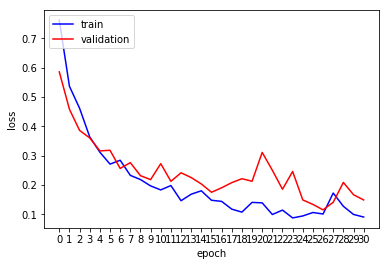

In [24]:
!rm -r {PATH}tmp
# F2 :  0.81 for learning_rate = 1e-4, lr=np.array([learning_rate/100,learning_rate/10,learning_rate]), dropout = [0.25,0.5] 
# F2 :  0.91 for learning_rate = 1e-4, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # good graph
# F2 :  0.93 (acc 94.51 %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5]
# F2 :  0.69 (acc 69.35 %) for learning_rate = 1e-2, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # graphs erratic but goes down
# F2 :  0.93 (acc 91.93 %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # graphs erratic at the end but goes down


learning_rate = 1e-3
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = 0.5
#[0.25,0.5] 


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]
#    [256, 128, 3],
#    [123, 300, 3],
#    [64, 600, 3],
#    [123, 300, 4],
#    [256, 128, 2],
#    [123, 300, 2],
#    [64, 600, 3],
#    [123, 400, 2]
for bs, sz, epoch in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", epoch, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, cycle_len=1, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)


[[148   7]                                   
 [ 10 145]]
Precision :  0.9548387096774194
Recall :  0.9367088607594937
F1 :  0.9456869009584665
F2 :  0.940279542566709


array([[148,   7],
       [ 10, 145]])

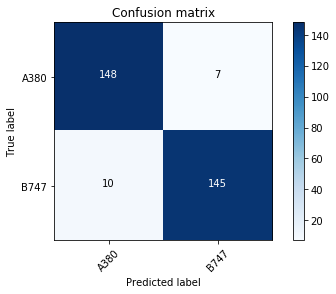

In [25]:
plot_the_confusion_matrix()

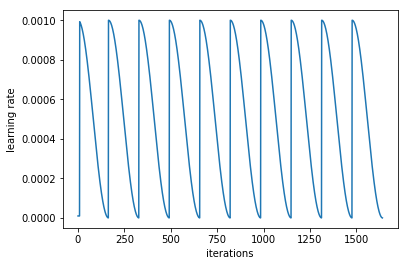

In [26]:
learn.sched.plot_lr()

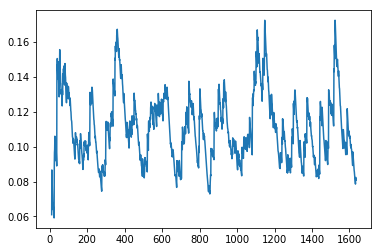

In [27]:
learn.sched.plot_loss()

## Variable cycle length

In [28]:
!rm -r {PATH}tmp

learning_rate = 1e-3
lr=np.array([learning_rate/50,learning_rate/10,learning_rate])
dropout = 0.5
#F2 :  0.96 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.92 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
#F2 :  0.86 for learning_rate = 1e-2, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.88 (acc 90    %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = 0.5 # graph go slowly down, better result at 29 epoch than 44
#F2 :  0.96 (acc 94.83 %) for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 3],
    [512, 64, 4],
    [256, 128, 3],
    [123, 400, 4]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)


Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.750071   0.567705   0.725806  
    1      0.608254   0.446691   0.790323                    
    2      0.471414   0.429624   0.8                         
    3      0.37804    0.328962   0.851613                    
    4      0.390706   0.323114   0.848387                    
    5      0.262953   0.298147   0.841935                    
    6      0.263688   0.295588   0.864516                    
After  7  epochs, the accuracy is  86.45 %
Saving to  resnext50_7_300_acc86.45_weights
Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.284471   0.298045   0.867742  
    1      0.255836   0.272631   0.9                         
    2      0.221528   0.278712   0.896774                    
    3      0.247728   0.227468   0.922581                    
    4      0.24941    0.260675   0.903226                    
    5      0.192021   0.243765   0.909677                    
    6      0.211273   0.287409   0.864516                    
    7      0.216395   0.248875   0.912903                    
    8      0.193634   0.217474   0.929032                    
    9      0.187003   0.218235   0.912903                    
    10     0.153748   0.228485   0.909677                    
    11     0.172677   0.21674    0.929032                    
    12     0.156507   0.218706   0.912903                    
    13     0.151215   0.2301     0.916129                    
    14     0.123921   0.204119   0.925806                    
After  22  epochs, the acc

epoch      trn_loss   val_loss   accuracy                    
    0      0.188647   0.224667   0.903226  
    1      0.148462   0.213022   0.909677                    
    2      0.13764    0.197618   0.935484                    
    3      0.165294   0.216389   0.912903                    
    4      0.120887   0.193359   0.916129                    
    5      0.162523   0.196589   0.932258                    
    6      0.124066   0.220072   0.906452                    
After  29  epochs, the accuracy is  90.64 %
Saving to  resnext50_29_128_acc90.64_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 400


epoch      trn_loss   val_loss   accuracy                    
    0      0.106054   0.183444   0.93871   
    1      0.112754   0.187842   0.948387                    
    2      0.130349   0.220217   0.912903                    
    3      0.147261   0.191728   0.922581                     
    4      0.158939   0.190463   0.932258                    
    5      0.119318   0.180549   0.945161                    
    6      0.124625   0.174042   0.932258                     
    7      0.141444   0.205793   0.935484                    
    8      0.1008     0.202048   0.929032                    
    9      0.074389   0.180103   0.954839                     
    10     0.110303   0.173827   0.945161                    
    11     0.087551   0.194871   0.935484                     
    12     0.067661   0.199189   0.929032                     
    13     0.095366   0.170363   0.941935                     
    14     0.098138   0.19343    0.919355                     
After  44  epochs, 

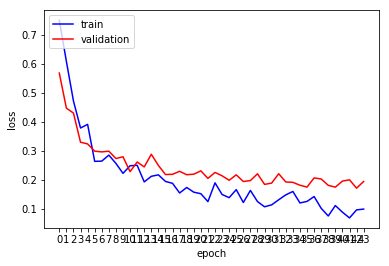

In [29]:
#plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)


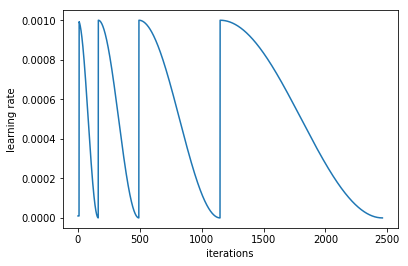

In [30]:
learn.sched.plot_lr()

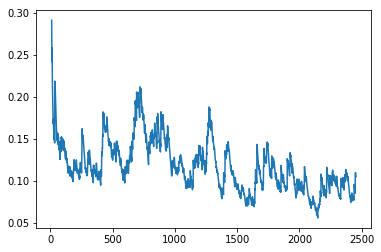

In [31]:
learn.sched.plot_loss()

[[147   8]                                   
 [  9 146]]
Precision :  0.9483870967741935
Recall :  0.9423076923076923
F1 :  0.9453376205787781
F2 :  0.9435173299101413


array([[147,   8],
       [  9, 146]])

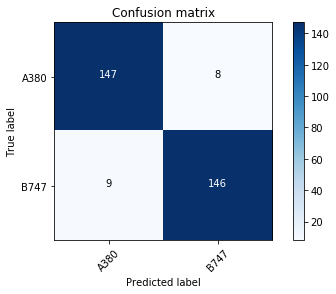

In [32]:
plot_the_confusion_matrix()

# More epochs and SWA

In [33]:
!rm -r {PATH}tmp
# resnext50 results :
#F2 :  0.95 (acc 91.29%) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # 
#F2 :  0.93 (acc 91.93%) with SWA=3 for learning_rate = 1e-2, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]XXX SWA = 3
#F2 :  0.95 (acc 91.29%) with SWA=3 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# and training_loop = [
#     [512, 64, 3, lr],
#     [256, 128, 4, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 4, lr/4]
# ]
# F2 :  0.96 (acc 95.48%), w/o SWA , learning_rate = 1e-3, [learning_rate/10,learning_rate/5,learning_rate], dropout = [0.25,0.5], 
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]


# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]


# resnet34 result :
    # F2 :  0.86 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
    
    
learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = [0.25,0.5]
#arch=resnet34
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, 299, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])


training_loop = [
    [512, 64, 4, lr*2],
    [256, 128, 3, lr],
    [123, 300, 3, lr],
    [64, 600, 3, lr],
    [123, 300, 6, lr/2],
    [64, 600, 3, lr/5],
    [123, 400, 4, lr/5]
]

for bs, sz, cycle, lr in training_loop:
    print("Hyperparameters for ", arch.__name__, " : Batch size=", bs, " Drop out=", dropout, " Learning rate=", lr, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True, use_swa=True, swa_start=3)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)



Hyperparameters for  resnext50  : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= [0.0002 0.0004 0.002 ]  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy   swa_loss   swa_accuracy 
    0      0.704752   0.579593   0.667742  
    1      0.567741   0.438972   0.787097                    
    2      0.388655   0.41142    0.796774   0.386513   0.809677  
    3      0.354532   0.357592   0.83871                     
    4      0.256174   0.222252   0.893548                    
    5      0.23627    0.194085   0.922581                    
    6      0.230428   0.194482   0.919355                    
    7      0.259099   0.249187   0.887097   0.22369    0.903226  
    8      0.189622   0.18927    0.916129                    
    9      0.206458   0.207122   0.916129                    
    10     0.188974   0.183626   0.929032                    
    11     0.257613   0.181345   0.919355                    
    12     0.093874   0.165357   0.935484   0.187437   0.912903  
    13     0.1148     0.152636   0.941935                    
    14     0.119218   0.15524    0.93871    0.178556   0.922581  
Aft

epoch      trn_loss   val_loss   accuracy   swa_loss   swa_accuracy 
    0      0.098079   0.156987   0.929032  
    1      0.130564   0.151049   0.93871                     
    2      0.143433   0.143056   0.932258   0.150633   0.929032  
    3      0.145289   0.233645   0.893548                     
    4      0.109548   0.137657   0.932258                     
    5      0.139967   0.144349   0.929032                    
    6      0.080633   0.154569   0.919355   0.139697   0.945161  
After  22  epochs, the accuracy is  91.93 %
Saving to  resnext50_22_128_acc91.93_weights
Hyperparameters for  resnext50  : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= [0.0001 0.0002 0.001 ]  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy   swa_loss   swa_accuracy 
    0      0.097894   0.148914   0.922581  
    1      0.121329   0.144865   0.941935                    
    2      0.159526   0.150086   0.932258   0.141936   0.93871   
    3      0.148399   0.161925   0.935484                    
    4      0.081573   0.136351   0.945161                     
    5      0.09846    0.122592   0.948387                     
    6      0.091684   0.136174   0.932258   0.130287   0.941935  
After  29  epochs, the accuracy is  93.22 %
Saving to  resnext50_29_300_acc93.22_weights
Hyperparameters for  resnext50  : Batch size= 64  Drop out= [0.25, 0.5]  Learning rate= [0.0001 0.0002 0.001 ]  Cycle= 3  Images sizes= 600


epoch      trn_loss   val_loss   accuracy   swa_loss   swa_accuracy 
    0      0.108055   0.149038   0.932258  
    1      0.091357   0.153123   0.929032                     
    2      0.082663   0.141607   0.932258   0.138775   0.935484  
    3      0.090731   0.173602   0.935484                     
    4      0.101454   0.17674    0.935484                     
    5      0.077613   0.171854   0.925806                     
    6      0.073728   0.142755   0.945161   0.133465   0.954839  
After  36  epochs, the accuracy is  94.51 %
Saving to  resnext50_36_600_acc94.51_weights
Hyperparameters for  resnext50  : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= [0.00005 0.0001  0.0005 ]  Cycle= 6  Images sizes= 300


epoch      trn_loss   val_loss   accuracy   swa_loss   swa_accuracy 
    0      0.140021   0.139106   0.948387  
    1      0.062074   0.154868   0.945161                     
    2      0.061744   0.157472   0.945161   0.148386   0.951613  
    3      0.072376   0.119328   0.951613                     
    4      0.112915   0.163337   0.929032                     
    5      0.05681    0.124053   0.945161                     
    6      0.113641   0.124862   0.941935                     
    7      0.063754   0.130663   0.941935   0.145971   0.929032  
    8      0.092761   0.195067   0.925806                     
    9      0.08969    0.149886   0.941935                     
    10     0.084895   0.11404    0.945161                     
    11     0.045797   0.132622   0.948387                     
    12     0.112506   0.111348   0.954839   0.136096   0.948387  
    13     0.079535   0.117424   0.951613                     
    14     0.074301   0.147408   0.935484                  

epoch      trn_loss   val_loss   accuracy   swa_loss   swa_accuracy 
    0      0.039872   0.111612   0.954839  
    1      0.058077   0.118918   0.948387                     
    2      0.050272   0.113737   0.951613   0.105506   0.958065  
    3      0.051854   0.119201   0.951613                     
    4      0.061297   0.097324   0.954839                     
    5      0.044429   0.119582   0.945161                     
    6      0.037374   0.147475   0.941935   0.103286   0.954839  
After  106  epochs, the accuracy is  94.19 %
Saving to  resnext50_106_600_acc94.19_weights
Hyperparameters for  resnext50  : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= [0.00002 0.00004 0.0002 ]  Cycle= 4  Images sizes= 400


epoch      trn_loss   val_loss   accuracy   swa_loss   swa_accuracy 
    0      0.035346   0.093544   0.954839  
    1      0.036397   0.106253   0.945161                     
    2      0.058439   0.118385   0.951613   0.100249   0.954839  
    3      0.067404   0.134579   0.93871                      
    4      0.036898   0.095607   0.964516                     
    5      0.044652   0.108762   0.948387                     
    6      0.063357   0.108316   0.958065                     
    7      0.069449   0.152124   0.932258   0.102102   0.954839  
    8      0.054137   0.14249    0.941935                     
    9      0.037926   0.11048    0.954839                     
    10     0.041907   0.099398   0.958065                     
    11     0.033806   0.122612   0.945161                     
    12     0.038818   0.096483   0.958065   0.101547   0.958065  
    13     0.02906    0.105374   0.958065                     
    14     0.050642   0.101236   0.958065   0.100248   0.96

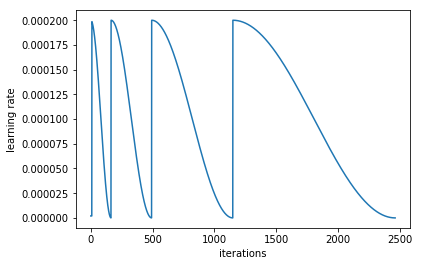

In [34]:
learn.sched.plot_lr()

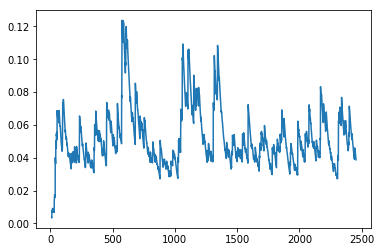

In [35]:
learn.sched.plot_loss()

<Figure size 1120x640 with 0 Axes>

[[151   4]                                   
 [  7 148]]
Precision :  0.9741935483870968
Recall :  0.9556962025316456
F1 :  0.9648562300319489
F2 :  0.9593392630241424


array([[151,   4],
       [  7, 148]])

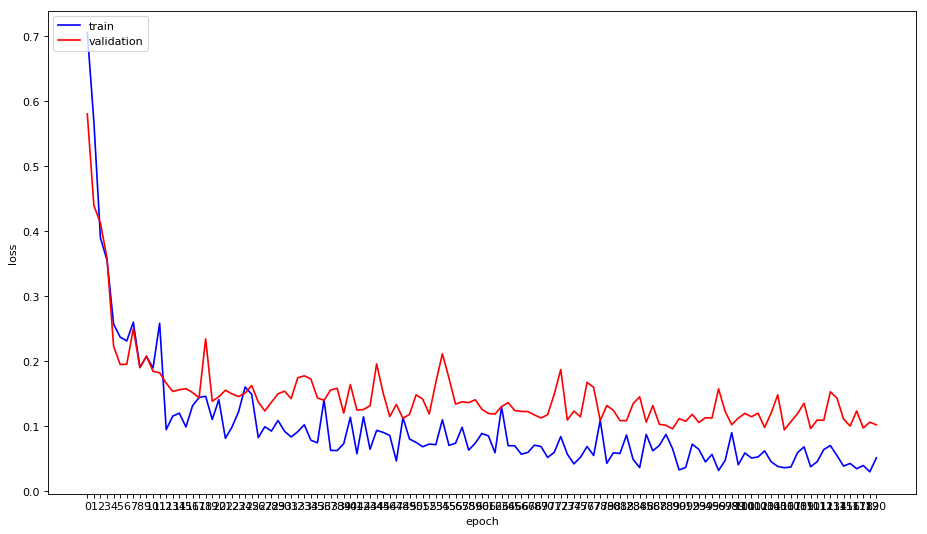

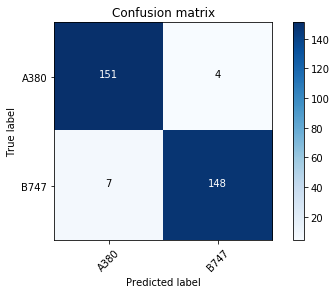

In [36]:

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [37]:
loadmodel=False
#loadmodel=True
if loadmodel==True:
    data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, 64), bs=123, num_workers=num_cpus())
    data = get_data(64, 64) 
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
    learn.load("resnext50_32_400_acc95.01_weights")
    learn.freeze()
    vals_s2s, global_results = learn.fit(0.00001, n_cycle=1, get_ep_vals=True)
    plot_ep_vals(global_results)
    print("Model chargé")

# Prediction et visualisation

[[152   3]                                   
 [  9 146]]
Precision :  0.9806451612903225
Recall :  0.9440993788819876
F1 :  0.9620253164556962
F2 :  0.9511889862327909


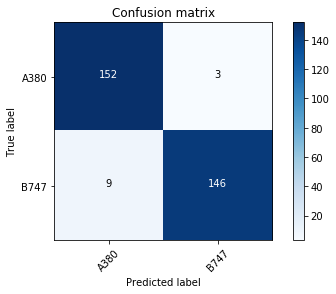

In [38]:
cm = plot_the_confusion_matrix()

In [39]:
#?plot_confusion_matrix

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [40]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.9806451612903225
recall :  0.9440993788819876
F1 :  0.9620253164556962
F2 :  0.9511889862327909


In [41]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

from math import ceil
nb_images = 6

# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), nb_images), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    nb_lignes = ceil(len(idxs) / 3)
    return plots(imgs, rows=nb_lignes, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:nb_images]] # Les nb_images premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

['A380', 'B747']

(310, 2)

Most incorrect A380


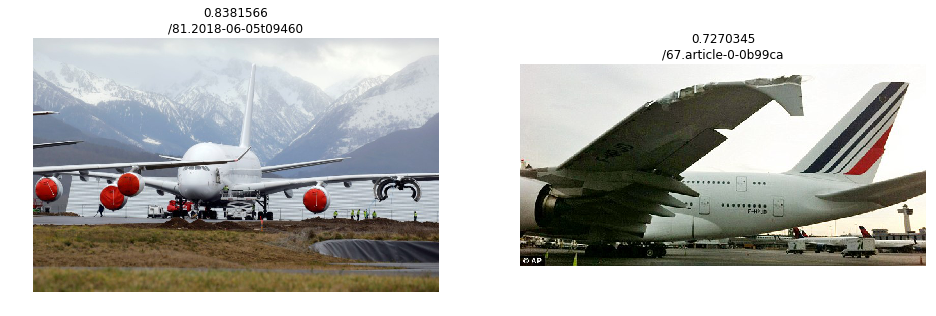

In [42]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

Most incorrect B747


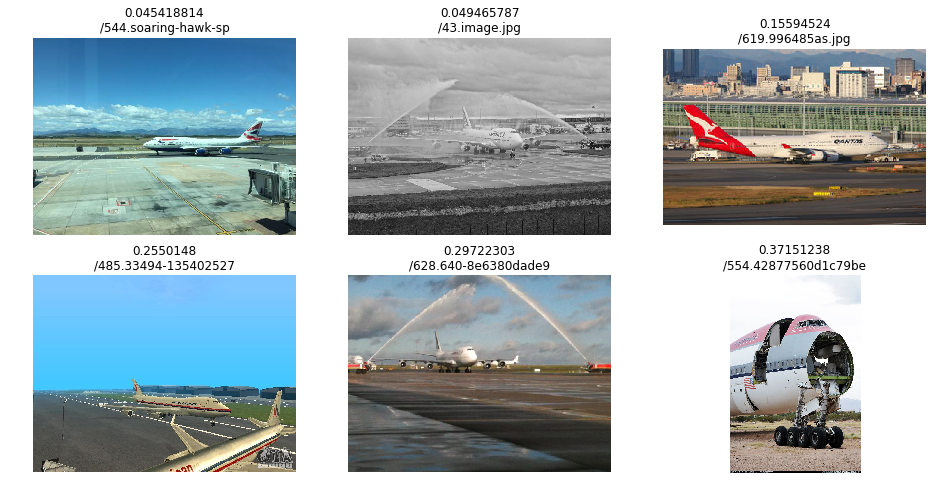

In [43]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

Most uncertain predictions


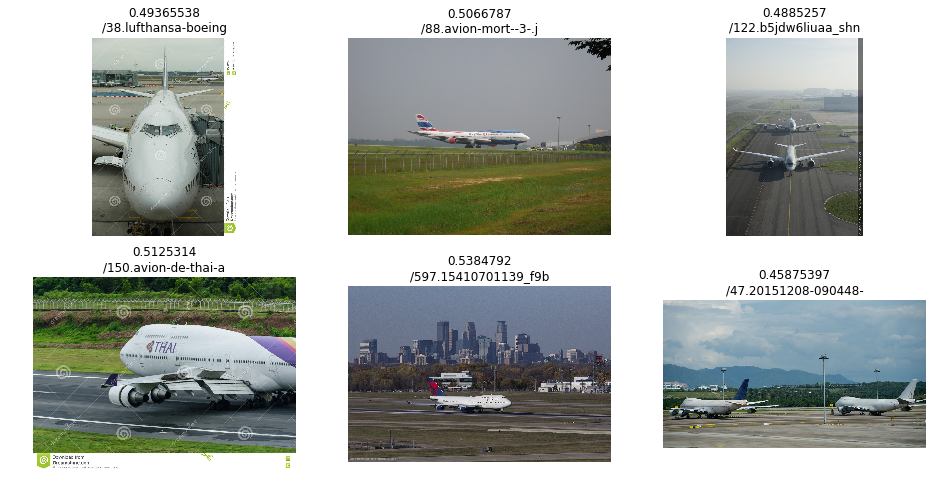

In [44]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:nb_images]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most correct B747


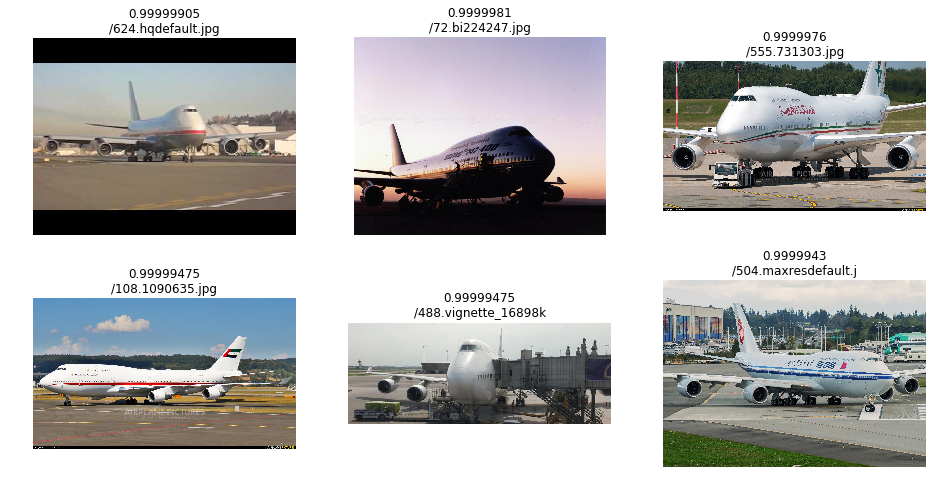

In [45]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

Most correct A380


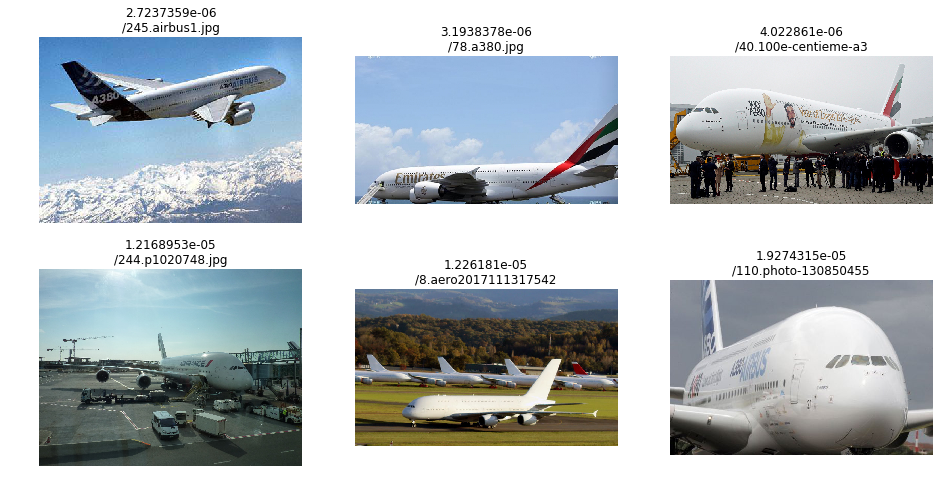

In [46]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

C'est bon, les plus petites font plus de 200 pixels.
On note que la majorité on une taille importante, il sera bon de faire des entrainement du modèle avec des tailles supérieures.

_"How many images should we use as a validation set? [01:26:28] Using 20% is fine unless the dataset is small — then 20% is not enough. If you train the same model multiple times and you are getting very different validation set results, then your validation set is too small. If the validation set is smaller than a thousand, it is hard to interpret how well you are doing. If you care about the third decimal place of accuracy and you only have a thousand things in your validation set, a single image changes the accuracy. If you care about the difference between 0.01 and 0.02, you want that to represent 10 or 20 rows. Normally 20% seems to work fine."_
=> Nous avons environs 100 images de validation par classes, ça devrait donc aller.

Faisons un test d'entrainement avec une petite taille de batch pour estimer la valeur du learning rate.